## scMKL workshop
Here, we will run scMKL with either unimodal or multimodal single-cell data. If you are using your own data, change the file paths with `_fp` append to them. 

In [1]:
import scmkl
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import load_npz

In [2]:
# For partioned data
# x_fp = '../example/data/_MCF7_RNA_X.npz'
# vars_fp = '../example/data/_MCF7_RNA_feature_names.npy'
# labs_fp = '../example/data/_MCF7_cell_labels.npy'

# x = load_npz(x_fp)
# var_names = np.load(vars_fp, allow_pickle=True)
# labs = np.load(labs_fp, allow_pickle=True)

In [3]:
# For .h5ad files
rna_fp = '../example/data/pbmc_rna.h5ad'
atac_fp = '../example/data/pbmc_atac.h5ad'

rna_adata = ad.read_h5ad(rna_fp)
atac_adata = ad.read_h5ad(atac_fp)

## Getting a gene grouping
scMKL requires grouping dictionaries to calculate ***Z*** matrices. To find possible libraries containing gene sets for our classification task, we can use the `scmkl.find_candidates()` function.

In [4]:
# Terms that we want in group names, sometimes appending a space helps
terms = ['b cell', 't cell', 'mono', 'nk', 'natural killer', 'dendritic', 'dc ']

# Terms we want to avoid
blist = ['stomach', 'bone']

scmkl.find_candidates(organism='human',
                      key_terms=terms,
                      blacklist=blist)

,Library,No. Gene Sets,No. Key Terms Matching,No. Blacklist Matching
0,Azimuth_2023,1241,154,64
1,Azimuth_Cell_Types_2021,341,52,0
2,Cancer_Cell_Line_Encyclopedia,967,2,63
3,CellMarker_2024,1134,341,84
4,CellMarker_Augmented_2021,1096,225,63
5,GO_Biological_Process_2025,5341,283,12
6,GO_Cellular_Component_2025,466,4,0
7,GO_Molecular_Function_2025,1174,53,0
8,KEGG_2021_Human,320,3,1
9,MSigDB_Hallmark_2020,50,0,0


Now that we have decided on a gene set library, we will pull and filter it with `scmkl.get_gene_groupings()`.

**NOTE:** Including `key_terms` or `blist` will filter output groups to only groups that contain one or more elements from `key_terms` and not `blist`. Additionally, including a list of gene names (from your dataset) will filter out groups that do not contain at least two genes from the input gene names as these groups would be filtered out in later steps of the workflow anyways. If you want the entire library only specify `lib_name` and `organism`.

In [6]:
gene_groups = scmkl.get_gene_groupings(lib_name='Azimuth_2023', 
                                       organism='human',
                                       key_terms=terms,
                                       blacklist=blist, 
                                       genes=rna_adata.var_names)
print(f"There are {len(gene_groups)} groups in `gene_groups`")

There are 138 groups in `gene_groups`


## Creating a region grouping

While there are many ways to group regions, the fastest is to group regions by inferrered promotor of genes from gene groupings. To do this, we need a GTF file. If your features are aligned to GRCh38/hg38, the 'Homo_sapiens.GRCh38.114.chr.gtf.gz' GTF will work.

In [7]:
# Reading in GTF and filtering to protein coding genes
gtf_fn = 'Homo_sapiens.GRCh38.114.chr.gtf.gz'
gtf = scmkl.read_gtf(gtf_fn, filter_to_coding=True)

# Using gene groupings and regions to create grouping dictionary
region_groups = scmkl.get_region_groupings(gtf, gene_groups, feature_names=atac_adata.var_names)

print(f"There are {len(region_groups)} groups in `region_groups`")

/home/vangordi/miniconda3/envs/trash/lib/python3.12/site-packages/scmkl/dataframes.py:687: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


There are 138 groups in `region_groups`


## Creating scMKL formatted AnnData object
There are two functions for creating AnnData objects. `scmkl.create_adata()` takes a single-cell dataset separated into the matrix, feature names, and cell labels. `scmkl.format_adata()` takes an existing AnnData object and adds the required variables to run scMKL. There are different parameters depending on if the input data matrix is binary (ATAC) or non-binary (such as RNA, ADT, ect...).

### Arguments
| Type | `scale_data` | `kernel_type` | `distance_metric` |
| ---- | ------------ | ------------- | ----------------- |
| non-binary | `True` | `'gaussian'` | `'euclidean'` |
| binary | `False` | `'laplacian'` | `'cityblock'` | 

In [ ]:
# For separated data
# adata = scmkl.create_adata(x, var_names, labs, gene_groups, 
#                            scale_data=True, 
#                            kernel_type='gaussian', 
#                            distance_metric='euclidean', 
#                            allow_multiclass=True)

In [ ]:
# For existing adata
rna_adata = scmkl.format_adata(rna_adata, 'celltypes', gene_groups, 
                               scale_data=True, 
                               kernel_type='gaussian', 
                               distance_metric='euclidean', 
                               allow_multiclass=True)

atac_adata = scmkl.format_adata(atac_adata, 'celltypes', region_groups, 
                                scale_data=False, 
                                kernel_type='laplacian', 
                                distance_metric='cityblock', 
                                allow_multiclass=True)

## Calculating Random Fourier Features

`scmkl.calculate_z()` will calculate kernel widths (*σ*) and random fourier features (***Z***) for each group.

In [ ]:
rna_adata = scmkl.calculate_z(rna_adata)

## Training and testing scMKL
To both train and test scMKL we can use `scmkl.run()` for binary problems or `scmkl.one_v_rest()` for multiclass problems.

In [ ]:
# Sparsity arguments to use
alpha_list = np.array([0.05, 0.5, 1])

# For binary classification
# results = scmkl.run(adata, alpha_list)

# For multiclass classification
results = scmkl.one_v_rest(adatas=[rna_adata],
                           names=['rna'], 
                           tfidf=[False],
                           alpha_list=alpha_list,
                           force_balance=True)

/home/vangordi/miniconda3/envs/new_scmkl/lib/python3.12/site-packages/scmkl/one_v_rest.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/home/vangordi/miniconda3/envs/new_scmkl/lib/python3.12/site-packages/scmkl/one_v_rest.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Comparing B to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing CD14+ Monocytes to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing CD16+ Monocytes to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing CD4 T to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing CD8 T to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing Dendritic to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0
Comparing NK to other types
  Evaluating model. Alpha: 0.05
  Evaluating model. Alpha: 0.5
  Evaluating model. Alpha: 1.0


## Evaluating results

In [ ]:
summary = scmkl.get_summary(results, metric='F1-Score')
summary

,Alpha,F1-Score,Number of Selected Groups,Top Group,Class
0,0.05,1.000000,40,PBMC-L2-Intermediate B Cell,B
1,0.50,0.987342,5,"PBMC-L3-Memory B Cell, Kappa Light Chain",B
2,1.00,0.987342,4,"PBMC-L3-Memory B Cell, Kappa Light Chain",B
0,0.05,0.864198,60,Tonsil-L1-Monocyte/macrophage,CD14+ Monocytes
1,0.50,0.800000,14,Tonsil-L2-DZ FDC,CD14+ Monocytes
2,1.00,0.747253,5,Tonsil-L2-DZ FDC,CD14+ Monocytes
0,0.05,0.961039,59,Adipose-L2-hMono2,CD16+ Monocytes
1,0.50,0.975000,10,PBMC-L2-CD16+ Monocyte,CD16+ Monocytes
2,1.00,0.950000,8,PBMC-L2-CD16+ Monocyte,CD16+ Monocytes
0,0.05,0.879121,79,Tonsil-L2-Nksig CD8 T,CD4 T


### Performance

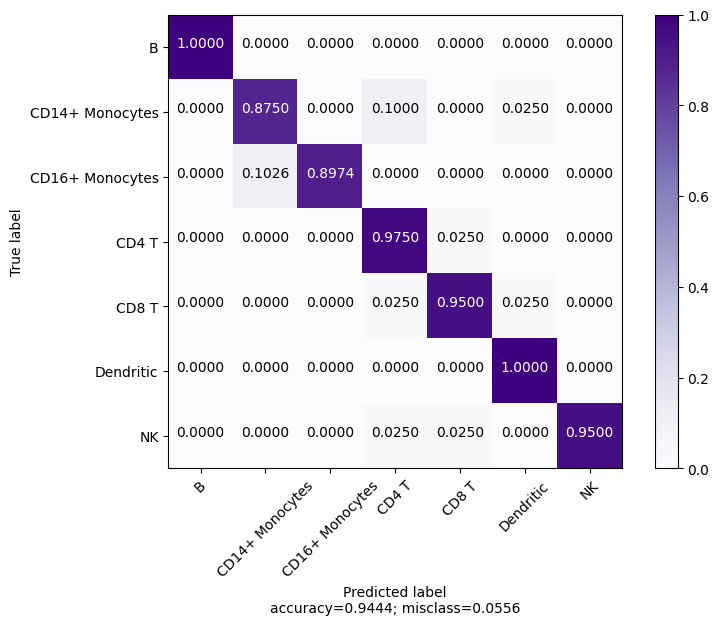

In [ ]:
# Confusion matrix for performance with smallest alpha
scmkl.plot_conf_mat(results, normalize=True)

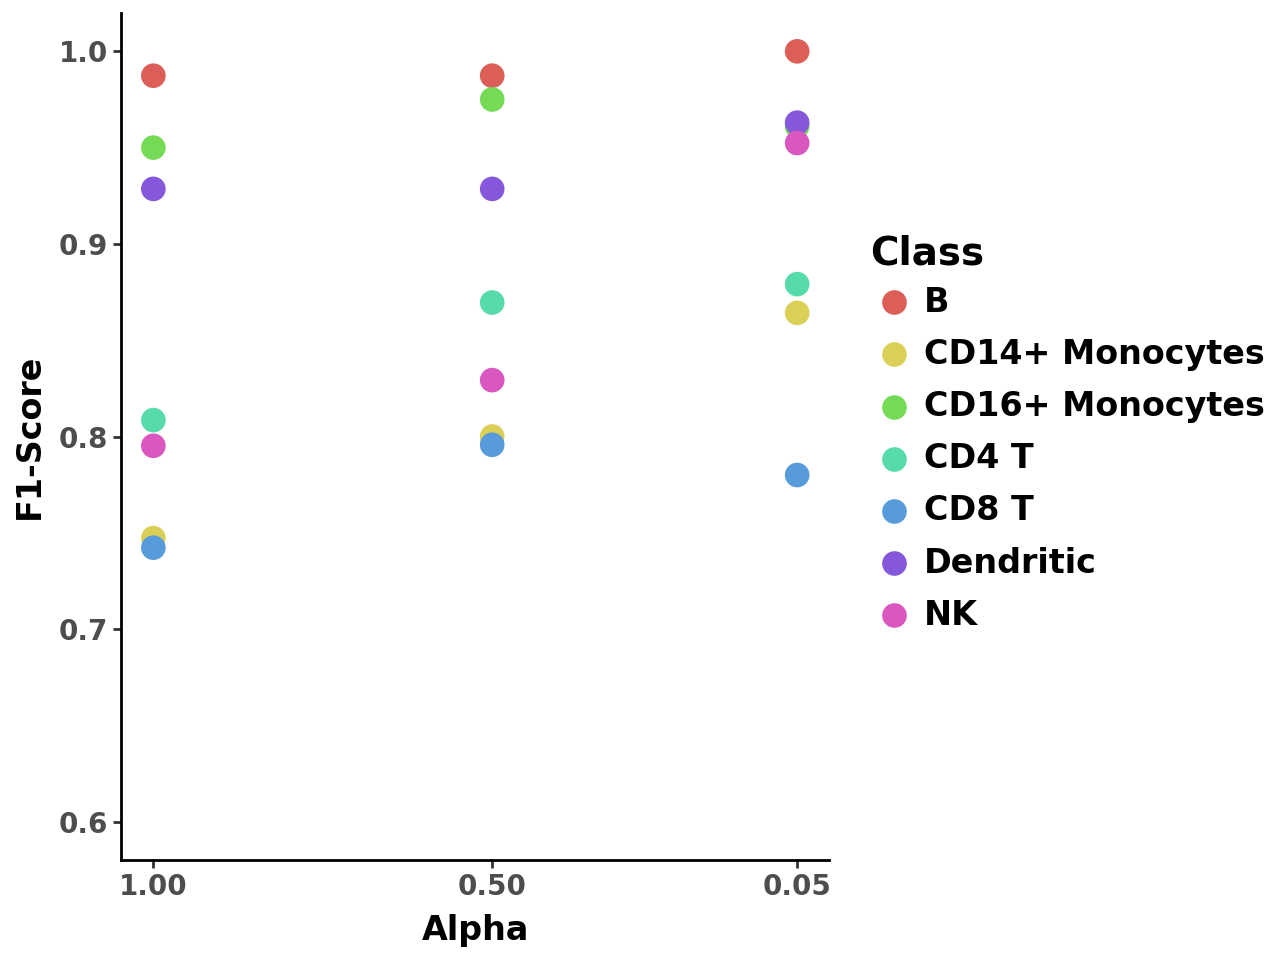

In [ ]:
scmkl.plot_metric(summary)

## Interpretation

/home/vangordi/miniconda3/envs/new_scmkl/lib/python3.12/site-packages/scmkl/plotting.py:467: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


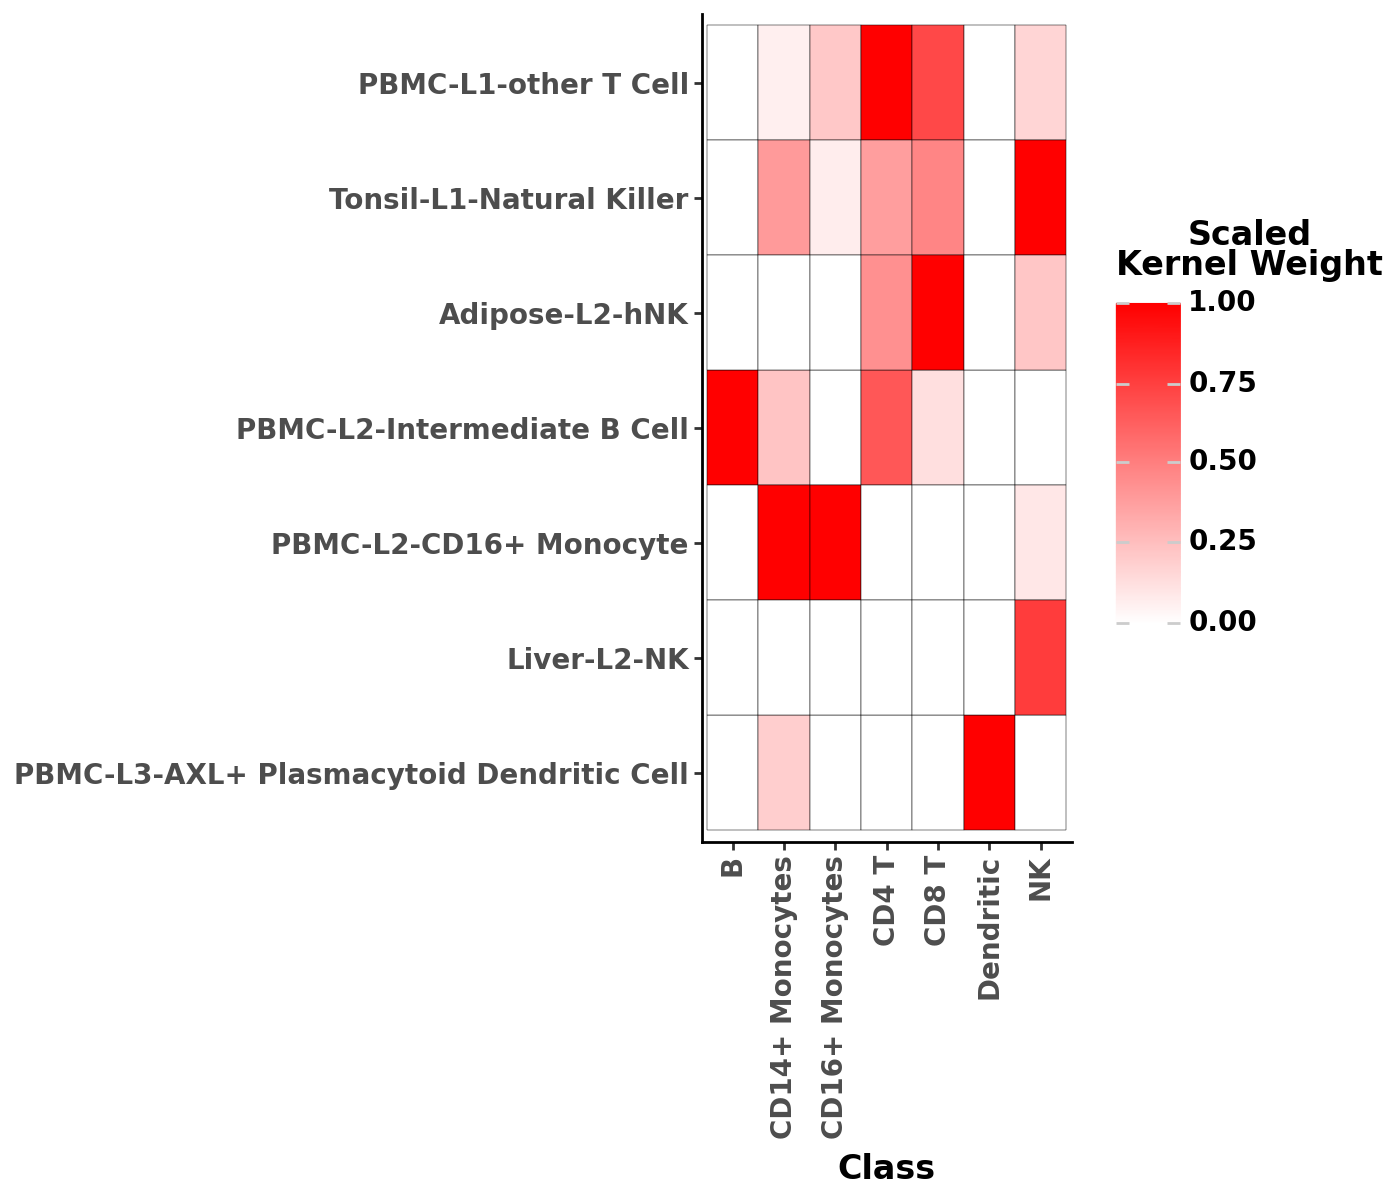

In [ ]:
scmkl.weights_heatmap(results, n_groups=7, scale_weights=True)

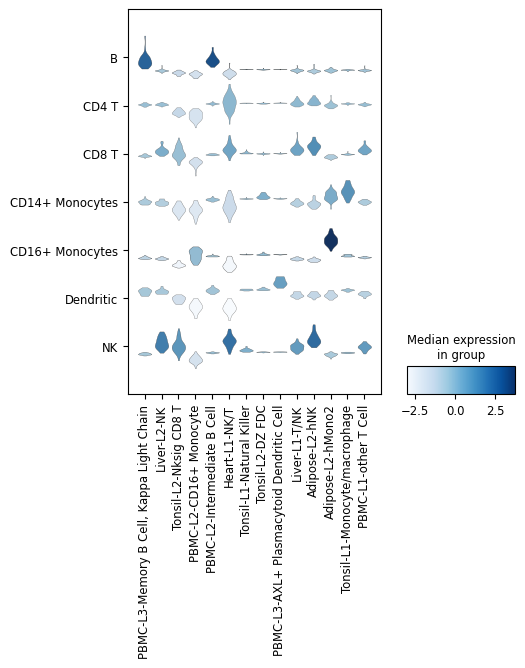

In [ ]:
# Capturing top groups
top_groups = list(set(summary['Top Group']))

# adata with only test samples
test_adata = rna_adata[rna_adata.uns['test_indices']].copy()

# Calculating module scores for top groups
for group in top_groups:
    sc.tl.score_genes(test_adata, gene_groups[group], score_name=group)

sc.pl.stacked_violin(test_adata, top_groups, 'labels', figsize=(5,5))

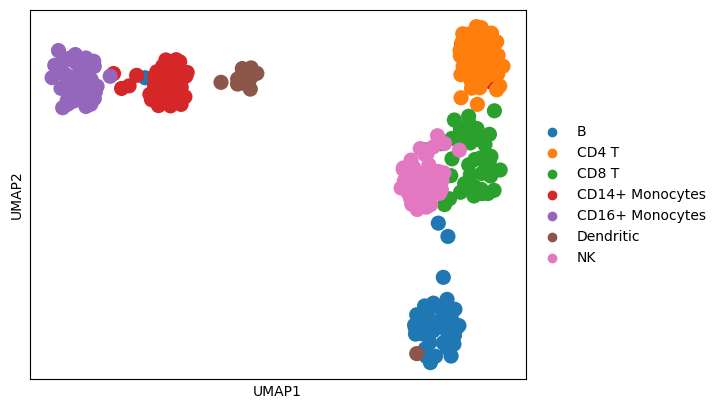

In [ ]:
scmkl.group_umap(test_adata, list(top_groups))

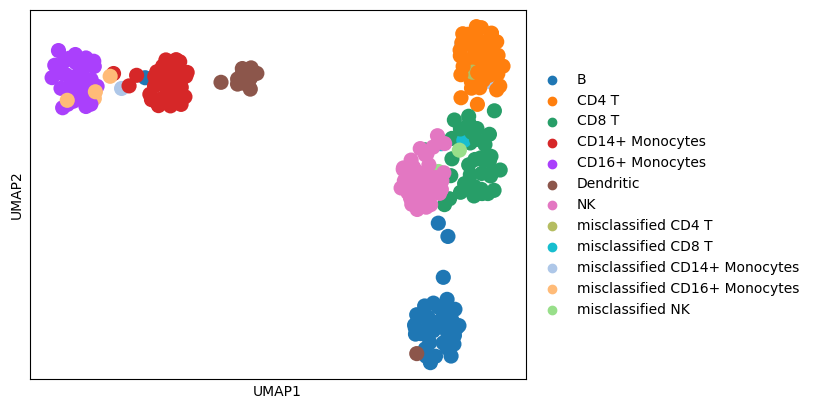

In [ ]:
preds = np.array(results['Predicted_class'])
truth = np.array(results['Truth_labels'])
new_labs = list()

for i, pred in enumerate(preds):
    if pred != truth[i]:
        new_labs.append(f'misclassified {truth[i]}')
    else:
        new_labs.append(pred)

scmkl.group_umap(test_adata, list(top_groups), labels=new_labs)
